In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
!pip3 install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/Users/mac/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-11 14:13:40.712212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#step 1 load up the data set
df = pd.read_csv('HSBAHistoricalData.csv')
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,16/10/2019,603.6,601.1,608.90,601.10,28.20M,-0.38%
1,15/10/2019,605.9,604.8,607.10,597.60,26.02M,-0.23%
2,14/10/2019,607.3,609.8,610.84,604.57,21.56M,-0.02%
3,11/10/2019,607.4,598.7,613.90,598.60,53.12M,1.57%
4,10/10/2019,598.0,599.6,602.10,595.90,20.92M,-1.09%


In [5]:
#the 'vol' column needs to be transformed to int and scaled to its real value(1000,000)

# Step 1: Extract Numeric Part and Convert to Float
df['Vol.'] = df['Vol.'].replace('[\$,M]', '', regex=True).astype(float)

# Step 2: Convert to Integers
df['Vol.'] = df['Vol.'].fillna(0).astype(int)

df.describe()

,Price,Open,High,Low,Vol.
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,674.514900,674.737202,681.529174,667.453616,35.026400
std,101.088135,100.899756,101.007672,101.150544,22.758543
min,6.750000,6.750000,6.750000,6.750000,0.000000
25%,615.575000,615.800000,622.200000,609.117500,20.000000
50%,673.180000,673.450000,680.900000,666.800000,29.000000
75%,743.140000,743.007500,749.870000,735.292500,43.000000
max,951.610000,953.350000,962.940000,935.050000,307.000000


In [6]:
# to see the data type of each column of the data set, number of colums, records and memory used
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5000 non-null   object 
 1   Price     5000 non-null   float64
 2   Open      5000 non-null   float64
 3   High      5000 non-null   float64
 4   Low       5000 non-null   float64
 5   Vol.      5000 non-null   int64  
 6   Change %  5000 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 273.6+ KB


In [7]:
#to see how the different variables in the dataset correlate with each other
df.corr()

/var/folders/l5/44cdf79173j5gfy0cg2f5xnh0000gn/T/ipykernel_54991/4165660069.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Price,Open,High,Low,Vol.
Price,1.000000,0.996377,0.997695,0.997343,0.060506
Open,0.996377,1.000000,0.997704,0.997048,0.062172
High,0.997695,0.997704,1.000000,0.995503,0.081610
Low,0.997343,0.997048,0.995503,1.000000,0.040874
Vol.,0.060506,0.062172,0.081610,0.040874,1.000000


In [8]:
#to check for duplicate rows
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Length: 5000, dtype: bool

In [9]:
#since we have a clean dataset we now visualize the data
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5000 non-null   datetime64[ns]
 1   Price     5000 non-null   float64       
 2   Open      5000 non-null   float64       
 3   High      5000 non-null   float64       
 4   Low       5000 non-null   float64       
 5   Vol.      5000 non-null   int64         
 6   Change %  5000 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 273.6+ KB


/var/folders/l5/44cdf79173j5gfy0cg2f5xnh0000gn/T/ipykernel_54991/410019974.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


Text(0.5, 1.0, 'HSBA Stock Price over the years')

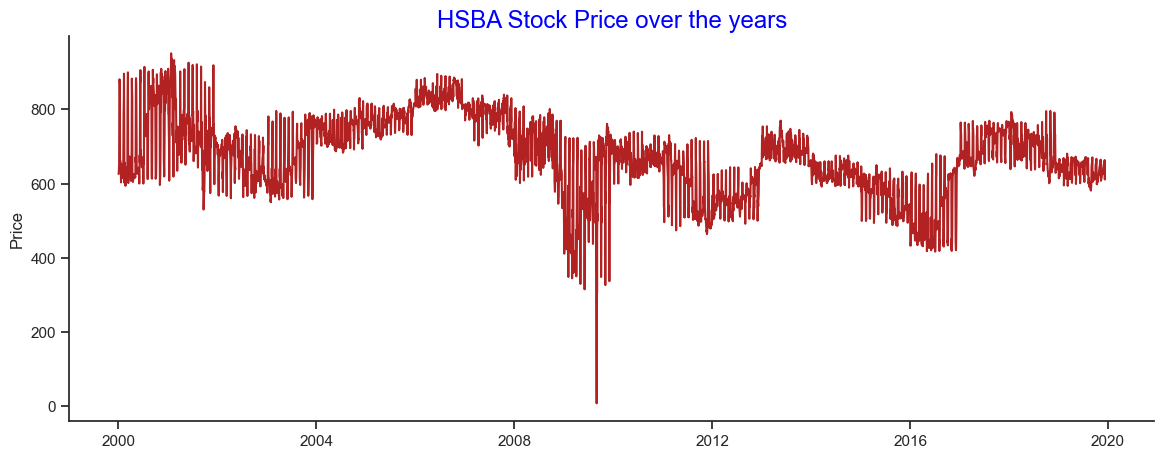

In [9]:
plt.figure(figsize=(14,5))
time = np.array(df.Date)
time = pd.to_datetime(time)
sns.set_style("ticks")
sns.lineplot(data=df,x= time,y='Price',color='firebrick')
sns.despine()
plt.title("HSBA Stock Price over the years",size='x-large',color='blue')


In [10]:
## Feature Engineering

# Feature Engineering
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Create Lag Features (e.g., lag of 1 day)
df['Price_Lag1'] = df['Price'].shift(1)
df['Volume_Lag1'] = df['Vol.'].shift(1)

# Calculate Price Change and Percentage Change
df['Price_Change'] = df['Price'] - df['Price_Lag1']
df['Price_Percentage_Change'] = (df['Price'] - df['Price_Lag1']) / df['Price_Lag1']

# Calculate Rolling Mean and Standard Deviation
df['Price_RollingMean'] = df['Price'].rolling(window=5).mean()
df['Price_RollingStd'] = df['Price'].rolling(window=5).std()

# Create 7-days and 14-days Moving Averages
df['Price_MA_7'] = df['Price'].rolling(window=7).mean()
df['Price_MA_14'] = df['Price'].rolling(window=14).mean()

# Drop unnecessary variables
# Drop NaN values introduced by feature engineering

df = df.dropna()
df = df.drop(['High', 'Low', 'Vol.', 'Change %'], axis=1)
df.head()


,Date,Price,Open,DayOfWeek,DayOfYear,Month,Year,Price_Lag1,Volume_Lag1,Price_Change,Price_Percentage_Change,Price_RollingMean,Price_RollingStd,Price_MA_7,Price_MA_14
13,2019-09-27,624.3,620.8,4,270,9,2019,624.6,16.0,-0.3,-0.000480,614.98,11.048394,611.585714,607.650000
14,2019-09-26,619.2,613.2,3,269,9,2019,624.3,19.0,-5.1,-0.008169,618.20,8.847316,613.714286,608.764286
15,2019-09-25,615.8,610.0,2,268,9,2019,619.2,28.0,-3.4,-0.005491,620.76,3.709852,615.700000,609.471429
16,2019-09-24,611.3,616.1,1,267,9,2019,615.8,20.0,-4.5,-0.007308,619.04,5.679172,616.871429,609.757143
17,2019-09-23,612.9,612.8,0,266,9,2019,611.3,18.0,1.6,0.002617,616.70,5.206246,618.285714,610.150000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4987 entries, 13 to 4999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     4987 non-null   datetime64[ns]
 1   Price                    4987 non-null   float64       
 2   Open                     4987 non-null   float64       
 3   DayOfWeek                4987 non-null   int64         
 4   DayOfYear                4987 non-null   int64         
 5   Month                    4987 non-null   int64         
 6   Year                     4987 non-null   int64         
 7   Price_Lag1               4987 non-null   float64       
 8   Volume_Lag1              4987 non-null   float64       
 9   Price_Change             4987 non-null   float64       
 10  Price_Percentage_Change  4987 non-null   float64       
 11  Price_RollingMean        4987 non-null   float64       
 12  Price_RollingStd         4987 non

/var/folders/l5/44cdf79173j5gfy0cg2f5xnh0000gn/T/ipykernel_54991/2411208296.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


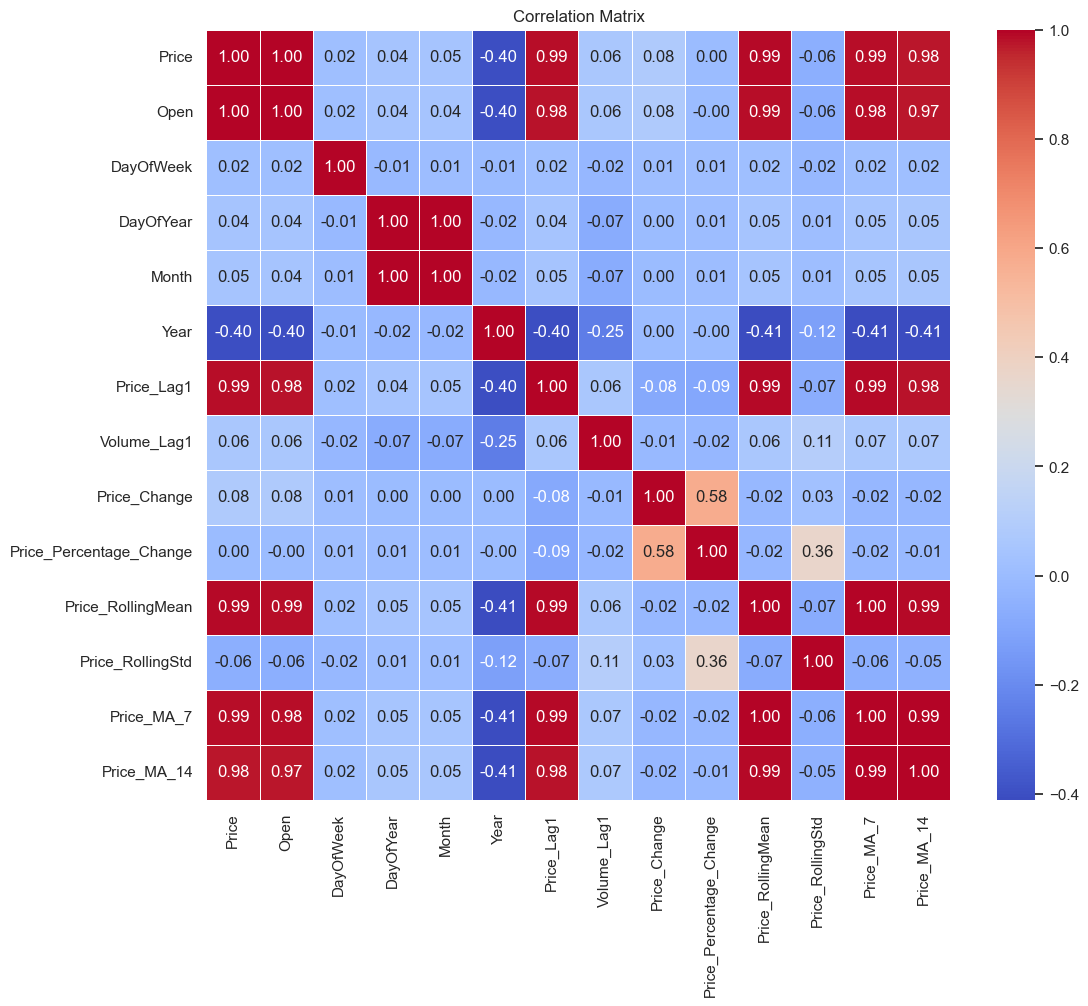

Highly correlated features (correlation > 0.7): ['Open', 'Month', 'Price_Lag1', 'Price_RollingMean', 'Price_MA_7', 'Price_MA_14']
Shape of X_train: (3989, 8)
Shape of X_test: (998, 8)


In [14]:

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Set a correlation threshold for feature selection
correlation_threshold = 0.7

# Select upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than the threshold
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Print highly correlated features
print(f"Highly correlated features (correlation > {correlation_threshold}): {highly_correlated_features}")

# Drop the highly correlated features from the DataFrame
df_selected_features = df.drop(highly_correlated_features, axis=1)

# Define X and y variables
X = df_selected_features.drop('Price', axis=1)
y = df_selected_features['Price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of X_train and X_test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


In [20]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame with the specified columns
# Convert 'Date' to a numerical representation (e.g., number of days since a reference date)
df['Date'] = (df['Date'] - df['Date'].min()).dt.days

# Define your features (X) and target variable (y)
X = df.drop(['Price'], axis=1)  # Exclude the target variable 'Price'
y = df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the fitted scaler
X_test_scaled = scaler.transform(X_test)


# Define sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[i:i + seq_length, 0])
        y.append(df[i + seq_length, 0])
    return np.array(X), np.array(y)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, sequence_length)

# Reshape for LSTM input
X_train_seq = np.reshape(X_train_seq, (X_train_seq.shape[0], sequence_length, 1))
X_test_seq = np.reshape(X_test_seq, (X_test_seq.shape[0], sequence_length, 1))

# Print the shape of X_train_seq before reshaping
print("Shape of X_train_seq before reshaping:", X_train_seq.shape)

# Print the shape of X_train_seq after reshaping
print("Shape of X_train_seq after reshaping:", X_train_seq.shape)


Shape of X_train_seq before reshaping: (3979, 10, 1)
Shape of X_train_seq after reshaping: (3979, 10, 1)


In [21]:
#Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
125/125 [==============================] - 5s 12ms/step - loss: 426347.4062
Epoch 2/10
125/125 [==============================] - 2s 12ms/step - loss: 291169.3125
Epoch 3/10
125/125 [==============================] - 2s 12ms/step - loss: 138235.6094
Epoch 4/10
125/125 [==============================] - 2s 12ms/step - loss: 44229.0703
Epoch 5/10
125/125 [==============================] - 2s 13ms/step - loss: 14764.4326
Epoch 6/10
125/125 [==============================] - 2s 12ms/step - loss: 10469.9170
Epoch 7/10
125/125 [==============================] - 2s 12ms/step - loss: 10186.6016
Epoch 8/10
125/125 [==============================] - 2s 13ms/step - loss: 10175.5420
Epoch 9/10
125/125 [==============================] - 2s 13ms/step - loss: 10173.4893
Epoch 10/10
125/125 [==============================] - 2s 13ms/step - loss: 10175.2520


In [26]:
#build ANN Model

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()

# Create an MLPRegressor
ann_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000)

# Reshape the input array and fit the model
ann_model.fit(X_train_array.reshape(X_train_array.shape[0], -1), y_train)


MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000)

In [27]:
#Build Random forest model

# Convert DataFrame to NumPy array
X_train_array = X_train.to_numpy()

# Create a RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Reshape the input array and fit the model
rf_model.fit(X_train_array.reshape(X_train_array.shape[0], -1), y_train)


RandomForestRegressor(random_state=42)

In [28]:
# Evaluating the models with RMSE

# Assuming X_test is a DataFrame

# Convert DataFrame to NumPy array
X_test_array = X_test.to_numpy()

# Evaluate LSTM
lstm_preds = lstm_model.predict(X_test_array)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))

# Evaluate ANN
ann_preds = ann_model.predict(X_test_array.reshape(X_test_array.shape[0], -1))
ann_rmse = np.sqrt(mean_squared_error(y_test, ann_preds))

# Evaluate Random Forest
rf_preds = rf_model.predict(X_test_array.reshape(X_test_array.shape[0], -1))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"LSTM RMSE: {lstm_rmse}")
print(f"ANN RMSE: {ann_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")


32/32 [==============================] - 1s 7ms/step
LSTM RMSE: 102.31147640451256
ANN RMSE: 6.524226074331207
Random Forest RMSE: 15.19852026957623


In [34]:
#Evaluating the models with MAE

from sklearn.metrics import mean_absolute_error

# Evaluate LSTM
lstm_mae = mean_absolute_error(y_test, lstm_preds)
print(f"LSTM MAE: {lstm_mae}")

# Evaluate ANN
# Assuming mlp_preds has the same length as y_test
mlp_preds_truncated = ann_preds[:len(y_test)]
ann_mae = mean_absolute_error(y_test, mlp_preds_truncated)
print(f"MLP MAE: {ann_mae}")

# Evaluate Random Forest
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest MAE: {rf_mae}")


LSTM MAE: 79.62019204179845
MLP MAE: 5.36196110119517
Random Forest MAE: 3.162714128256515


In [42]:
#Evaluating the models with MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

# Evaluate LSTM
lstm_mape = mean_absolute_percentage_error(y_test, lstm_preds)
print(f"LSTM MAPE: {lstm_mape:.2f}%")

# Evaluate ANN
ann_mape = mean_absolute_percentage_error(y_test, ann_preds)
print(f"ANN MAPE: {ann_mape:.2f}%")

# Evaluate Random Forest
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)
print(f"Random Forest MAPE: {rf_mape:.2f}%")

LSTM MAPE: 22.47%
ANN MAPE: 1.64%
Random Forest MAPE: 7.15%


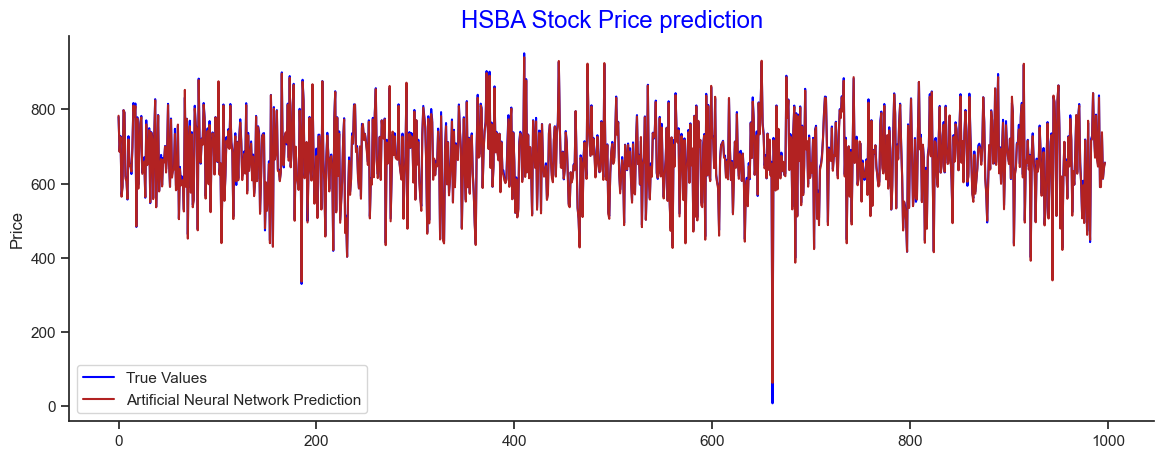

In [41]:
# Plotting the Random forest predictions against the y_test to compare model perfromance graphically
xpoints = range(len(y_test))
ypoints_true = y_test
ypoints_preds = ann_preds.flatten()

plt.figure(figsize=(14, 5))
sns.set_style("ticks")
sns.lineplot(x=xpoints, y=ypoints_true, color='blue', label='True Values')
sns.lineplot(x=xpoints, y=ypoints_preds, color='firebrick', label='Artificial Neural Network Prediction')
sns.despine()
plt.title("HSBA Stock Price prediction", size='x-large', color='blue')
plt.legend()
plt.show()